# Introduction: Looking at Data to Correct Cognitive Biases



In this notebook, we will investigate a simple problem: is the smoking rate higher in the metro area of my hometown (Peoria, Il) or in Boston. The purpose is to see if I can combat my cognitive biases with data and explore the data to determine why I made a incorrect conclusion.

# City Level Data

https://nccd.cdc.gov/500_Cities/rdPage.aspx?rdReport=DPH_500_Cities.ComparisonReport&Locations=1759000,2507000&rdRequestForwarding=Form

![](images/rates_smoking.PNG)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Boston
b_p = 0.164
b_ci = [0.161, 0.166]
b_adults = 472582
b_smokers = b_p * b_adults

# Peoria
p_p = 0.199
p_ci = [0.194, 0.203]
p_adults = 83925
p_smokers = p_p * p_adults

## Difference Between Two Proportions

This is assuming 10% of adults in each city surveyed. 

Relevant Data:

* Boston number of adults = 472582: https://www.bumc.bu.edu/inspir/files/HTML/Boston%20Population%20and%20Demographics.htm
* Peoria number of adults = 83925: https://www.infoplease.com/us/illinois/demographic-statistics-61
* Boston smoking rate = 0.164 (from first source in image)
* Peoria smoking rate = 0.199(from first source in image)

z-score for 95% CI: http://www.stat.yale.edu/Courses/1997-98/101/confint.htm

Difference between two proportions formula: https://onlinecourses.science.psu.edu/stat100/node/57/

In [3]:
# Standard errors individual
b_se = np.sqrt((b_p * (1 - b_p)) / (0.1 * b_adults))
p_se = np.sqrt((p_p * (1 - p_p)) / (0.1 * p_adults))

# Standard error combined
se_diff = np.sqrt(np.square(b_se) + np.square(p_se))

z_95 = 1.96

# Upper confidence bound for difference (two-tailed)
uci = (p_p - b_p) + z_95 * se_diff
# Lower confidence bound
lci = (p_p - b_p) - z_95 * se_diff

print(f'The 95% confidence interval for difference between smoking rates is from {round(100 * lci, 4)}% to {round(100 * uci, 4)}%')

The 95% confidence interval for difference between smoking rates is from 2.5829% to 4.4171%


This indicates the difference is significant. We can also tell this from the non-overlapping individual confidence intervals.

# Distributions

If we assume the smoking rate proportion is normally distributed then we can construct a normal distribution and sample from it. Then we can visually show the data in boxplots.

In [4]:
z_95 = 1.96

b_sigma = ((b_ci[1] - b_p) / z_95) * 1
p_sigma = ((p_ci[1] - p_p) / z_95) * 1

print(f'Standard deviation for Boston: {b_sigma}')
print(f'Standard deviation for Peoria: {p_sigma}')

# Sample distributions 
p_dist = np.random.normal(loc = p_p, scale = p_sigma, size = 100000)
b_dist = np.random.normal(loc = b_p, scale = b_sigma, size = 100000)
# Names
b = np.repeat('boston', repeats = len(b_dist))
p = np.repeat('peoria', repeats = len(p_dist))

Standard deviation for Boston: 0.001020408163265307
Standard deviation for Peoria: 0.002040816326530614


Confidence interval for Boston.

In [5]:
from scipy import stats
b_ci = stats.norm.interval(0.95, loc = b_p, scale = b_sigma)
b_ci

(0.16200003675046934, 0.16599996324953067)

Confidence interval for Peoria

In [6]:
p_ci = stats.norm.interval(0.95, loc = p_p, scale = p_sigma)
p_ci

(0.19500007350093868, 0.20299992649906135)

The confidence intervals from our simulated data are basically the same as those from the survey data. The survey data does have uneven confidence intervals though. 

In [7]:
import pandas as pd
dist_df = pd.DataFrame({'proportion': list(b_dist) + list(p_dist)})
dist_df['city'] = list(b) + list(p)
dist_df.groupby('city').describe()

proportion                                                              \
            count      mean       std       min       25%       50%       75%   
city                                                                            
boston   100000.0  0.163997  0.001022  0.159868  0.163306  0.163995  0.164686   
peoria   100000.0  0.199008  0.002040  0.190101  0.197626  0.198997  0.200389   

                  
             max  
city              
boston  0.168289  
peoria  0.207784

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
default_c = plt.rcParams['axes.prop_cycle'].by_key()['color']


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


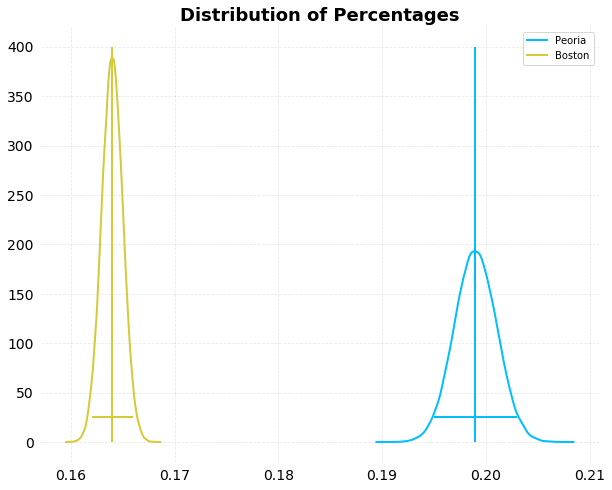

In [9]:
import seaborn as sns
plt.figure(figsize = (10, 8))
p1 = sns.kdeplot(p_dist, label = 'Peoria')
p2 = sns.kdeplot(b_dist, label = 'Boston')
plt.legend(); plt.title('Distribution of Percentages');

# Means and confidence intervals
plt.vlines([b_p, p_p], ymin = 0, ymax = 400, colors = ['#D4CA3A', '#00BEFF']);
plt.hlines([25], xmin = b_ci[0], xmax = b_ci[1], colors = ['#D4CA3A'], linestyles = '-')
plt.hlines([25], xmin = p_ci[0], xmax = p_ci[1], colors = ['#00BEFF'], linestyles = '-');

The confidence interval for Boston is slightly narrower. Boxplots are a good way to show a distribution.

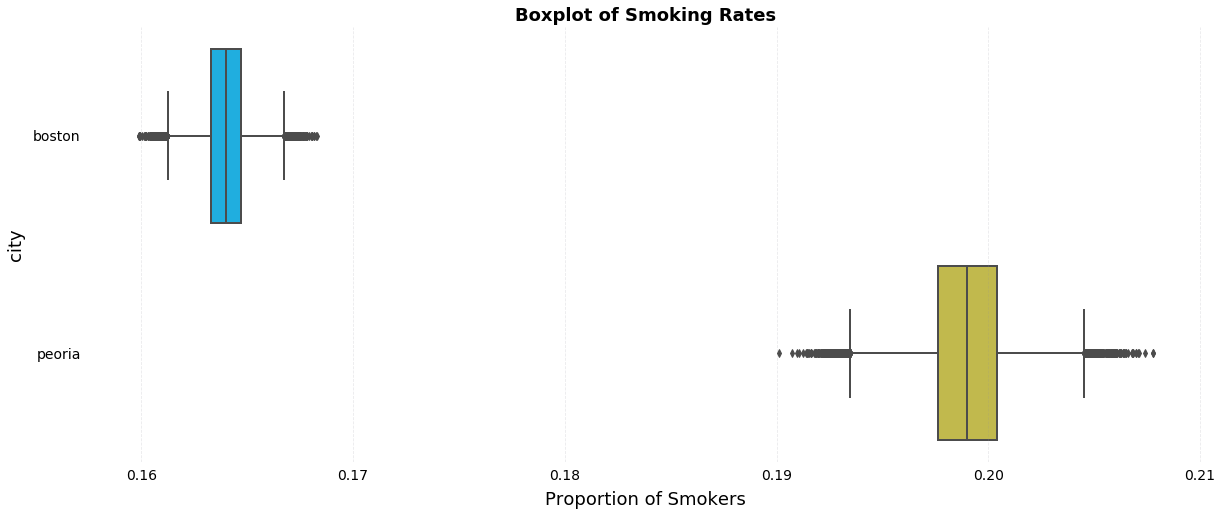

In [10]:
plt.rcParams['font.size'] = 32
plt.figure(figsize = (20, 8))
sns.boxplot(x = 'proportion', y = 'city', data = dist_df);
plt.xlabel('Proportion of Smokers');
plt.title('Boxplot of Smoking Rates');

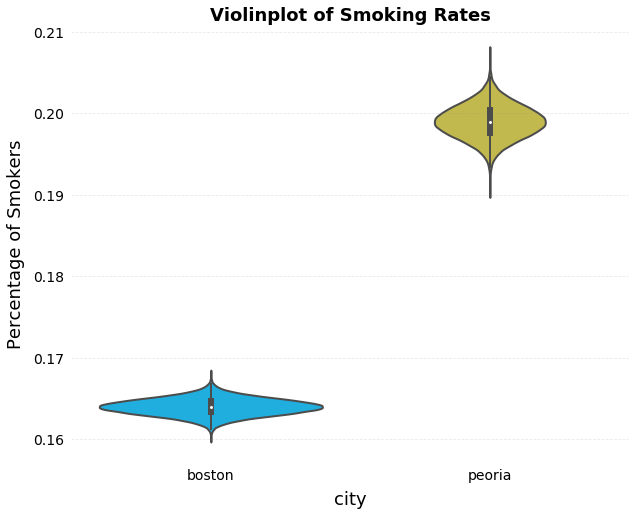

In [11]:
plt.figure(figsize = (10, 8))
sns.violinplot(y = 'proportion', x = 'city', data = dist_df);
plt.ylabel('Percentage of Smokers');
plt.title('Violinplot of Smoking Rates');

# How Many Smokers Do I See Per Day?

To show why I would see many more smokers in Boston, we can simulate 10,000 days with the known rates and the number of people I meet in my hometown and Boston. Putting it in these terms shows why I would be susceptible to the availability heuristic.

In [12]:
n_samples = 10000
people_meet_peoria = 50
peoria_see = np.random.binomial(1, p_p, size = (n_samples, people_meet_peoria))
peoria_smokers = np.sum(peoria_see, axis = 1)

In [13]:
people_meet_boston = 5000
boston_see = np.random.binomial(1, p_p, size = (n_samples, people_meet_boston))
boston_smokers = np.sum(boston_see, axis = 1)

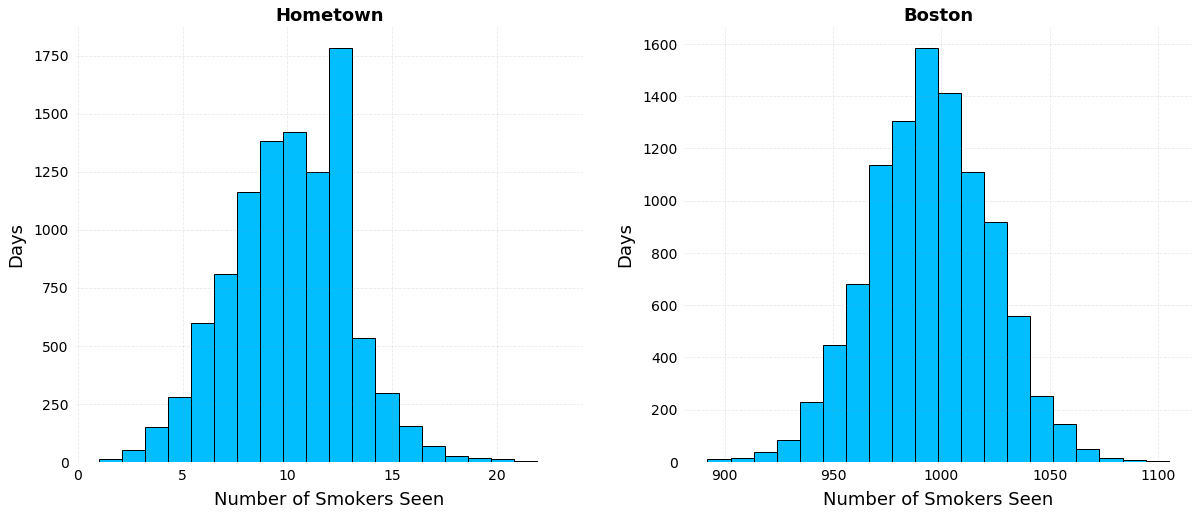

In [14]:
plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.xlabel('Number of Smokers Seen'); plt.title('Hometown'); plt.ylabel('Days');
plt.hist(peoria_smokers, bins = 20, edgecolor = 'k');
plt.subplot(1, 2, 2)
plt.hist(boston_smokers, bins = 20, edgecolor = 'k');
plt.xlabel('Number of Smokers Seen'); plt.title('Boston'); plt.ylabel('Days');

# Costs

Out of curiousity, I wanted to calculate the economic costs of smoking and compare these to the revenues from taxes. 


In [15]:
total_cost = 326_000_000_000
n_smokers = 37_800_000
cost_per_smoker = total_cost / n_smokers
cost_per_smoker

8624.338624338625

In [16]:
n_packs = 1
days = 365 

p_packtax = 1.98
b_packtax = 3.51

In [17]:
p_revenue = p_smokers * p_packtax * n_packs * days
b_revenue = b_smokers * b_packtax * n_packs * days

print(f'Tax revenue in Peoria from smoking: ${p_revenue:,.2f}.')
print(f'Tax revenue in Boston from smoking: ${b_revenue:,.2f}.')

Tax revenue in Peoria from smoking: $12,069,866.90.
Tax revenue in Boston from smoking: $99,293,542.41.


In [18]:
p_cost = cost_per_smoker * p_smokers
b_cost = cost_per_smoker * b_smokers

print(f'Cost to Peoria from smoking: ${p_cost:,.2f}.')
print(f'Cost to Boston from smoking: ${b_cost:,.2f}.')

Cost to Peoria from smoking: $144,035,726.19.
Cost to Boston from smoking: $668,415,980.11.


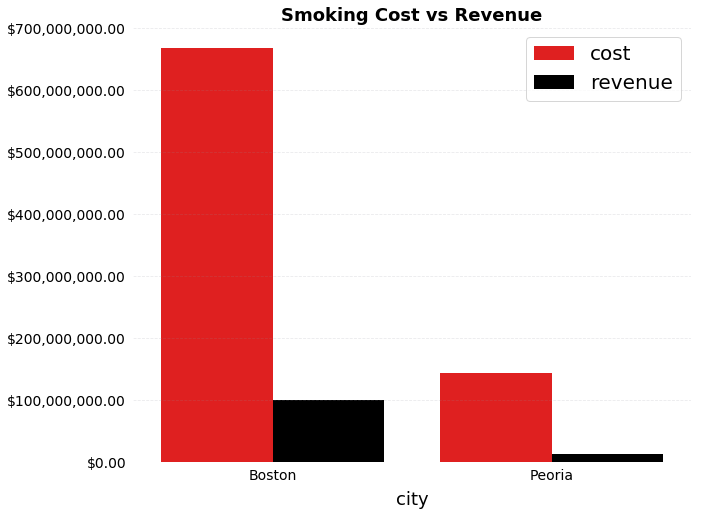

In [19]:
data = pd.DataFrame({'value': [b_cost, p_cost, b_revenue, p_revenue],
                     'metric': ['cost', 'cost', 'revenue', 'revenue'],
                     'city': ['Boston', 'Peoria', 'Boston', 'Peoria']})

plt.figure(figsize = (10, 8))

ax = sns.barplot(x = 'city', y = 'value', hue = 'metric', palette= {'cost': 'red', 'revenue': 'black'}, 
                 data = data)
tick_labels = [f'${x:,.2f}' for x in ax.yaxis.get_ticklocs()]
plt.legend(prop = {'size': 20})
plt.title('Smoking Cost vs Revenue')
plt.ylabel(None)
ax.yaxis.set_ticklabels(tick_labels);

# Break Even Point for Tax Per Pack

To figure out how high taxes should be to make revenue equal to cost, we can find the point where $\text{cost} == \text{revenue}$

$$\text{tax_required} = \frac{\text{cost_per_smoker}}{\text{days} * \text{n_packs}}$$

In [20]:
tax_required = cost_per_smoker / (days * n_packs)

print(f'Breaking even requires a tax of ${tax_required:,.2f} per pack.')

Breaking even requires a tax of $23.63 per pack.


## Revenue vs Tax with Constant Smoking Rate

This plot shows the revenue versus tax per pack with no decrease in the number of smokers.

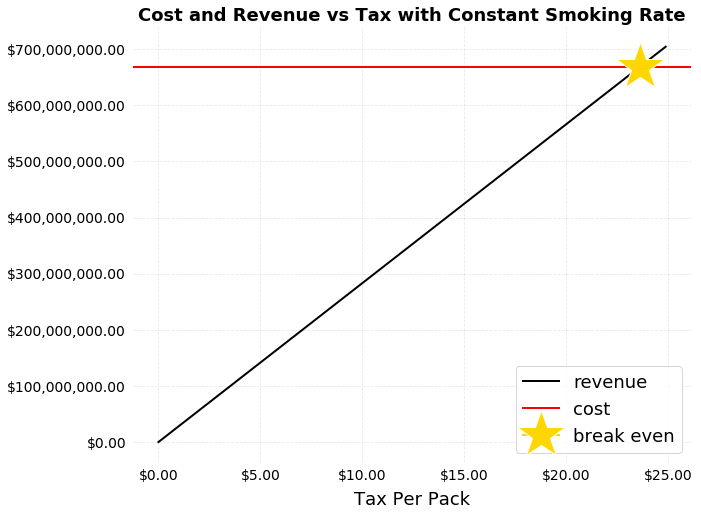

In [21]:
tax =  np.arange(0, 25, 0.1)
revenue = [b_smokers * n_packs * days * x for x in tax]
cost = [b_smokers * cost_per_smoker for _ in range(len(revenue))]

plt.figure(figsize = (10, 8))
plt.plot(tax, revenue, label = 'revenue', color = 'black')
plt.axhline(y = cost[0], label = 'cost', color = 'red')
plt.plot(tax_required, cost[0], marker = '*', ms = 50, color = 'gold', label = 'break even');
plt.legend(prop = {'size': 18})
ax = plt.gca()
tick_labels = [f'${x:,.2f}' for x in ax.yaxis.get_ticklocs()]
ax.yaxis.set_ticklabels(tick_labels);
tick_labels = [f'${x:,.2f}' for x in ax.xaxis.get_ticklocs()]
ax.xaxis.set_ticklabels(tick_labels);
plt.xlabel("Tax Per Pack"); plt.ylabel(None); plt.title('Cost and Revenue vs Tax with Constant Smoking Rate');


In reality, the number of smokers declines as the tax per pack increases. We can account for this affect by finding the difference in smoking rates in Boston and Peoria and comparing this to the difference in tax rates between Boston and Peoria (assuming these two cities are indicative of the nation).

For every $1.00 increase in revenue, there is a -2.29% decline in smokers.
There are 0 smokers at a tax of $10.50 per pack.


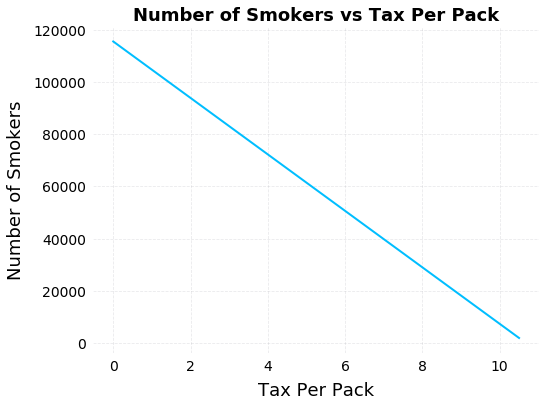

In [22]:
decline = (p_p - b_p) / (p_packtax - b_packtax)
print(f'For every $1.00 increase in revenue, there is a {100 * decline:.2f}% decline in smokers.')
rb_smokers = [b_adults * (b_p + (decline * (x - b_packtax))) for x in tax]
rb_smokers = rb_smokers[:np.argmax(np.where(np.array(rb_smokers) > 0))]
rtax =  tax[:len(rb_smokers)]

print(f'There are 0 smokers at a tax of ${max(rtax):,.2f} per pack.')

rrevenue = [rb_smokers[i] * n_packs * days * x for i, x in enumerate(rtax)]
rcost = [rb_smokers[i] * cost_per_smoker for i in range(len(rrevenue))]


plt.figure(figsize = (8, 6))
plt.plot(rtax, rb_smokers, label = 'Number of Smokers')
tick_labels = [f'${x:,.2f}' for x in ax.xaxis.get_ticklocs()]
ax.xaxis.set_ticklabels(tick_labels);
plt.xlabel('Tax Per Pack'); plt.ylabel('Number of Smokers');
plt.title('Number of Smokers vs Tax Per Pack');

This seems reasonable. What it means, is that at a certain point, there are no more smokers because of the tax per pack (probably not realistic)!

## Revenue vs Tax Rate with Declining Rate of Smoking

Now we can make the same plot accounting for the declining rate in smokers to see if there is a break-even point in this situation. This is a very simple model but can still be useful.

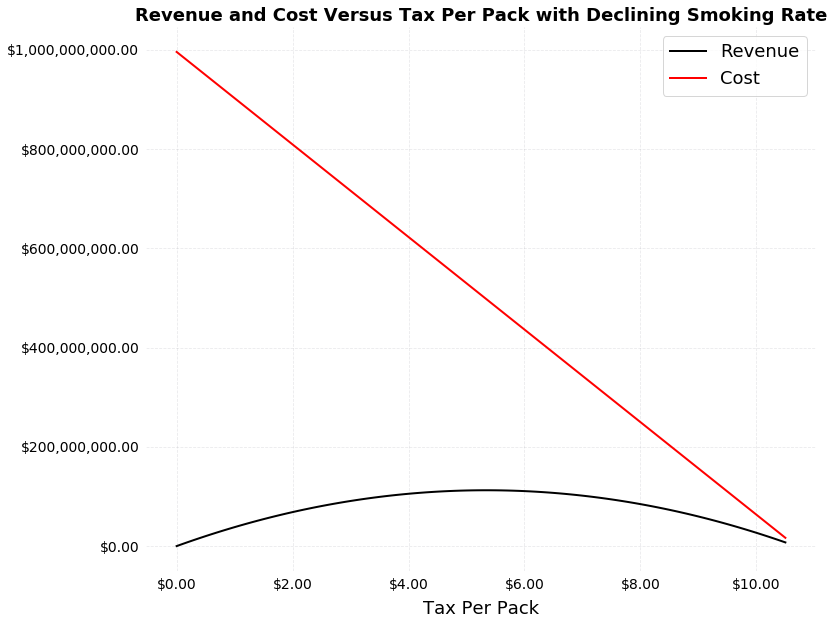

In [23]:
plt.figure(figsize = (12, 10))

plt.plot(rtax, rrevenue, label = 'Revenue', color = 'black')
plt.plot(rtax, rcost, label = 'Cost', color = 'red')
plt.legend(prop = {'size': 18})
ax = plt.gca()
tick_labels = [f'${x:,.2f}' for x in ax.yaxis.get_ticklocs()]
ax.yaxis.set_ticklabels(tick_labels);
tick_labels = [f'${x:,.2f}' for x in ax.xaxis.get_ticklocs()]
ax.xaxis.set_ticklabels(tick_labels);

plt.ylabel(None); plt.xlabel('Tax Per Pack');
plt.title('Revenue and Cost Versus Tax Per Pack with Declining Smoking Rate');

# Conclusions 

In the final plot, we see there is no break even point in terms of cost to society versus revenue from smoking. On the whole, we can conclude two things:

* Smoking rates are significantly higher in my home town
* Smoking is a negative to society 

Hopefully, this notebook has given you a small idea of what you can do by playing with the data yourself. Looking at facts is one thing, but trying to see how they are important in your life can make them stand out. 

![](images/national_smoking_time.png)
(Source: https://news.gallup.com/poll/237908/smoking-rate-hits-new-low.aspx)

National smoking rates over time have clearly declined! Just more evidence the world is improving. (Relevant Book: [Enlightenment Now](https://www.penguinrandomhouse.com/books/317051/enlightenment-now-by-steven-pinker/9780525427575/))